# Integraded Surface Database (ISD) - Global Summary of the Day
NOAA

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.calibration import calibration_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
import glob
import shap

In [87]:
# Read all CSVs and combine them into one dataframe 
file_path = "./data/*.csv"
csv_files = glob.glob(file_path)

dataframes = []
for file in csv_files:
    temp_df = pd.read_csv(file, dtype={'FRSHTT': str})
    dataframes.append(temp_df)

df = pd.concat(dataframes, ignore_index=True)

# Display the first row
df.iloc[0]

STATION                         1001099999
DATE                            2024-01-01
LATITUDE                         70.933333
LONGITUDE                        -8.666667
ELEVATION                              9.0
NAME                JAN MAYEN NOR NAVY, NO
TEMP                                  26.6
TEMP_ATTRIBUTES                         24
DEWP                                  20.5
DEWP_ATTRIBUTES                         24
SLP                                 1016.6
SLP_ATTRIBUTES                          24
STP                                   15.4
STP_ATTRIBUTES                          24
VISIB                                 15.5
VISIB_ATTRIBUTES                         4
WDSP                                  13.1
WDSP_ATTRIBUTES                         24
MXSPD                                 21.0
GUST                                  27.8
MAX                                   32.9
MAX_ATTRIBUTES                            
MIN                                   17.4
MIN_ATTRIBU

In [88]:
df.shape

(12029, 28)

In [89]:
df.describe(include='all').iloc[:,4:]

,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,SLP,SLP_ATTRIBUTES,STP,STP_ATTRIBUTES,...,MXSPD,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT
count,12029.000000,12029,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,...,12029.000000,12029.000000,12029.000000,12029,12029.000000,12029,12029.000000,12029,12029.000000,12029
unique,NaN,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,NaN,2,NaN,8,NaN,19
top,NaN,"TROMSO, NO",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,,NaN,,NaN,I,NaN,000000
freq,NaN,516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8647,NaN,8454,NaN,4820,NaN,7291
mean,79.723211,NaN,38.310550,17.509519,775.869316,17.062516,6084.283789,5.736304,712.949855,5.737385,...,79.394680,707.427683,63.405063,NaN,54.327126,NaN,22.128487,NaN,886.244135,NaN
std,164.080168,NaN,17.987774,8.332916,2620.104156,8.908203,4457.891653,8.634899,445.963315,8.634995,...,238.220029,445.917063,444.692155,NaN,463.255219,NaN,41.479421,NaN,314.725824,NaN
min,0.000000,NaN,-44.400000,4.000000,-50.600000,0.000000,956.600000,0.000000,0.000000,0.000000,...,0.400000,9.700000,-32.300000,NaN,-46.300000,NaN,0.000000,NaN,0.400000,NaN
25%,10.000000,NaN,27.300000,8.000000,22.300000,8.000000,1013.200000,0.000000,20.500000,0.000000,...,11.700000,38.100000,31.100000,NaN,22.600000,NaN,0.000000,NaN,999.900000,NaN
50%,18.000000,NaN,39.200000,24.000000,36.000000,24.000000,9999.900000,0.000000,999.900000,0.000000,...,17.500000,999.900000,42.800000,NaN,35.600000,NaN,0.000000,NaN,999.900000,NaN
75%,81.000000,NaN,53.000000,24.000000,48.300000,24.000000,9999.900000,8.000000,999.900000,8.000000,...,24.700000,999.900000,58.300000,NaN,46.900000,NaN,0.230000,NaN,999.900000,NaN


In [90]:
df = df.loc[:, ~df.columns.str.endswith('_ATTRIBUTES')]
df = df.drop(['STATION', 'NAME', 'DATE'], axis=1)
df.describe()

,LATITUDE,LONGITUDE,ELEVATION,TEMP,DEWP,SLP,STP,VISIB,WDSP,MXSPD,GUST,MAX,MIN,PRCP,SNDP
count,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000,12029.000000
mean,70.923271,19.770038,79.723211,38.310550,775.869316,6084.283789,712.949855,463.038449,72.960163,79.394680,707.427683,63.405063,54.327126,22.128487,886.244135
std,4.729113,8.486055,164.080168,17.987774,2620.104156,4457.891653,445.963315,493.877841,239.641684,238.220029,445.917063,444.692155,463.255219,41.479421,314.725824
min,59.791925,-8.666667,0.000000,-44.400000,-50.600000,956.600000,0.000000,0.100000,0.000000,0.400000,9.700000,-32.300000,-46.300000,0.000000,0.400000
25%,69.450000,16.250000,10.000000,27.300000,22.300000,1013.200000,20.500000,6.200000,6.100000,11.700000,38.100000,31.100000,22.600000,0.000000,999.900000
50%,70.068814,21.883333,18.000000,39.200000,36.000000,9999.900000,999.900000,24.600000,10.000000,17.500000,999.900000,42.800000,35.600000,0.000000,999.900000
75%,71.100000,25.066667,81.000000,53.000000,48.300000,9999.900000,999.900000,999.900000,16.000000,24.700000,999.900000,58.300000,46.900000,0.230000,999.900000
max,80.650000,31.500000,982.000000,78.100000,9999.900000,9999.900000,999.900000,999.900000,999.900000,999.900000,999.900000,9999.900000,9999.900000,99.990000,999.900000


In [91]:
total_nulls = int(df.isnull().sum().sum())
f"There are {total_nulls} null values"

'There are 0 null values'

In [92]:
# Convert the label column to one-hot encoded format
labels = df['FRSHTT'].apply(lambda x: list(map(int, x[2]))) # x[2] is snow or ice pellets
labels = np.array(labels.tolist())

# Drop the original label column from the DataFrame
df = df.drop(columns=['FRSHTT'])

# Features (X)
X = df.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [93]:
%%time

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for binary classification
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
    }

# Train the model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

# Make predictions for each label
pred = np.zeros(X_test.shape[0])

dtest = xgb.DMatrix(X_test)
preds = model.predict(dtest)

# Convert predictions to binary (0 or 1)
preds_binary = (preds > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, preds_binary)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 95.26%
CPU times: user 1.03 s, sys: 73.5 ms, total: 1.1 s
Wall time: 692 ms


In [94]:
# Evaluate each model
dtest = xgb.DMatrix(X_test)
preds = model.predict(dtest)

# Convert predictions to binary
preds_binary = (preds > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, preds_binary)
precision = precision_score(y_test, preds_binary)
recall = recall_score(y_test, preds_binary)
f1 = f1_score(y_test, preds_binary)

# Calculate ROC AUC
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

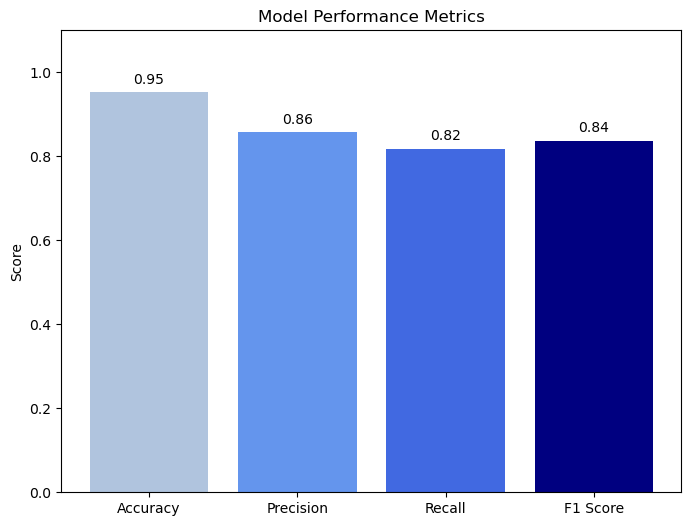

In [95]:
# Bar Plot of Accuracy, Precision, Recall, and F1 Score
metrics = [accuracy, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
plt.bar(metric_names, metrics, color=['lightsteelblue', 'cornflowerblue', 'royalblue', 'navy'])
plt.ylim([0, 1.1])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

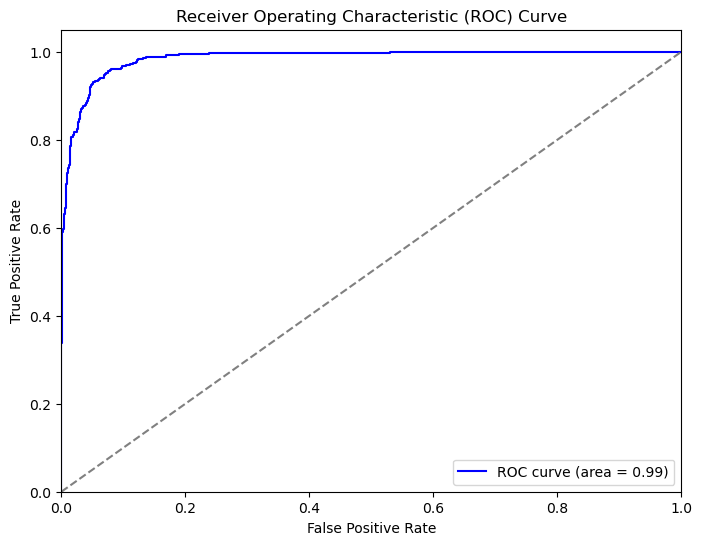

In [96]:
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray',) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

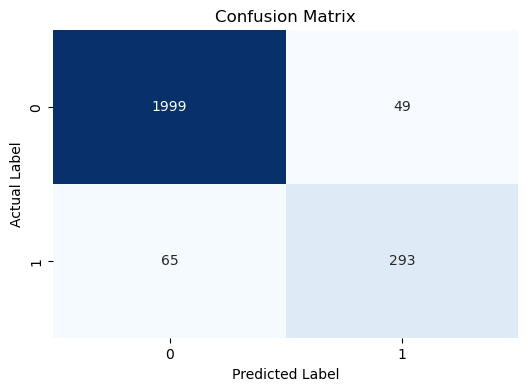

In [97]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

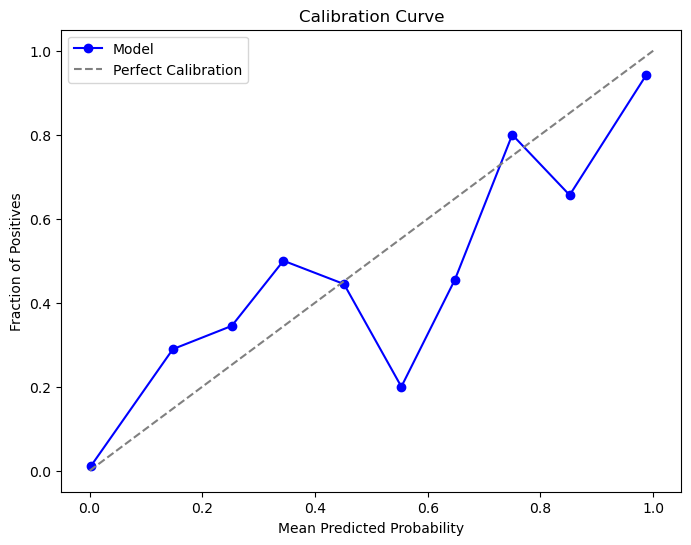

In [98]:
# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', color='blue', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

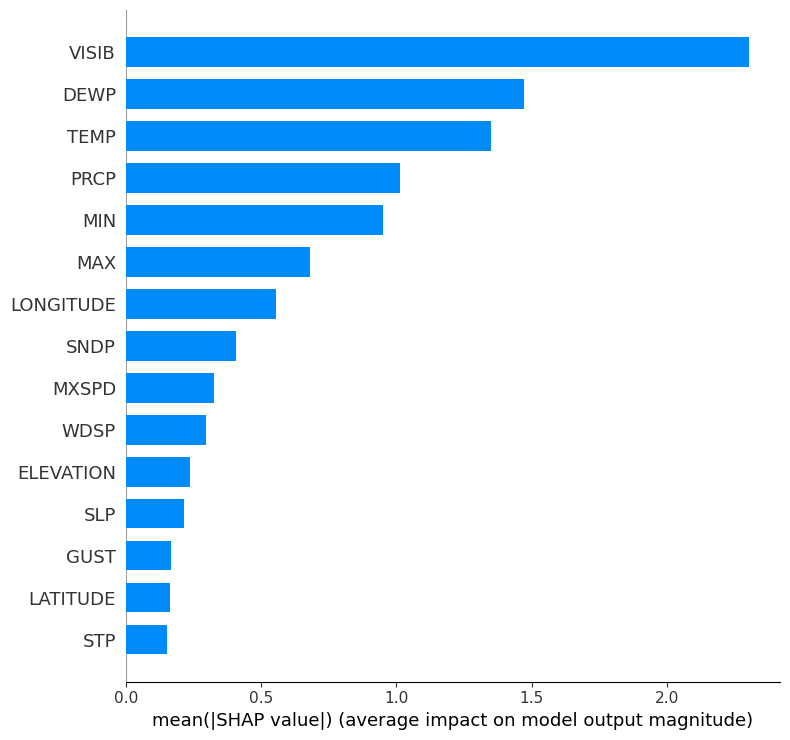

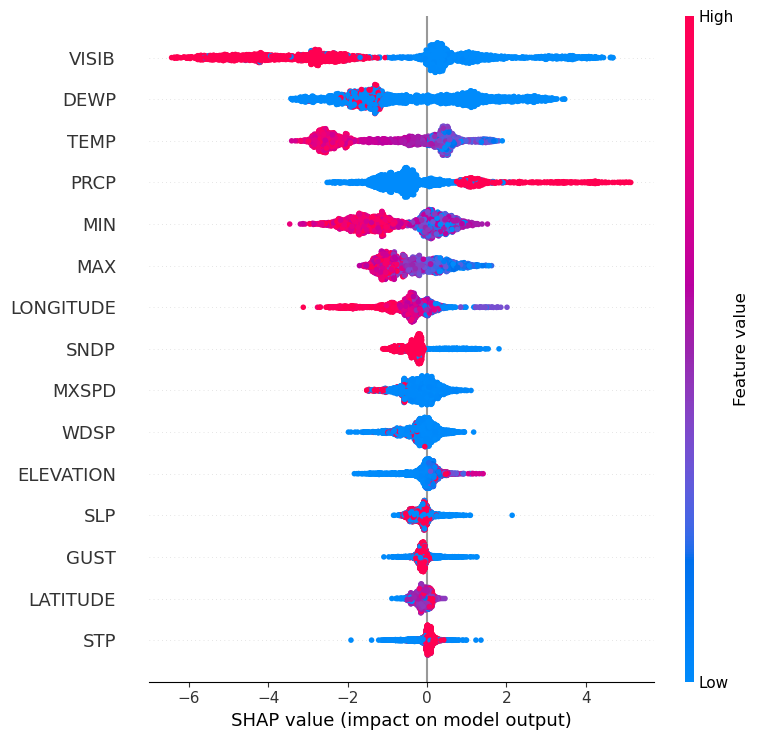

In [99]:
feature_names = df.columns.tolist()

# Calculate SHAP values for the test dataset
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot summary of SHAP values for all features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=feature_names)  # Bar plot of mean SHAP values per feature
plt.show()

# You can also generate a detailed summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_names)  # Standard summary plot (scatter)
plt.show()